In [1]:
import numpy as np
import cv2
from skimage import io
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

def get_obj2img_points():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = io.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        #print(corners.shape)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    #print(len(imgpoints))
    return ret,images,objpoints,imgpoints



def get_cal_undistort_param(img_size , objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
   
    return ret,mtx,dist



gbl_img_sizeX = -1
gbl_img_sizeY = -1


def get_list_img_sizeYX():
    global gbl_img_sizeX
    global gbl_img_sizeY
    
    if(gbl_img_sizeX<=0):
        img = io.imread('./camera_cal/calibration1.jpg')
        gbl_img_sizeX=img.shape[0]
        gbl_img_sizeY=img.shape[1]
    
    img_size=[gbl_img_sizeY,gbl_img_sizeX]
    
    return img_size    

def get_tuple_img_sizeYX():
    global gbl_img_sizeX
    global gbl_img_sizeY
    
    if(gbl_img_sizeX<=0):
        img = io.imread('./camera_cal/calibration1.jpg')
        gbl_img_sizeX=img.shape[0]
        gbl_img_sizeY=img.shape[1]
    
    img_size=(gbl_img_sizeY,gbl_img_sizeX)
    
    return img_size    
    

In [2]:
import numpy as np
from skimage import io
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

ret00,images,objpoints,imgpoints= get_obj2img_points()

    
    
####################################################
#img_size = (img.shape[1], img.shape[0])
img_size=get_tuple_img_sizeYX()
ret01,mtx,dist=get_cal_undistort_param(img_size, objpoints, imgpoints)
####################################################


print(ret00)
print(ret01)

True
1.1956513730179685


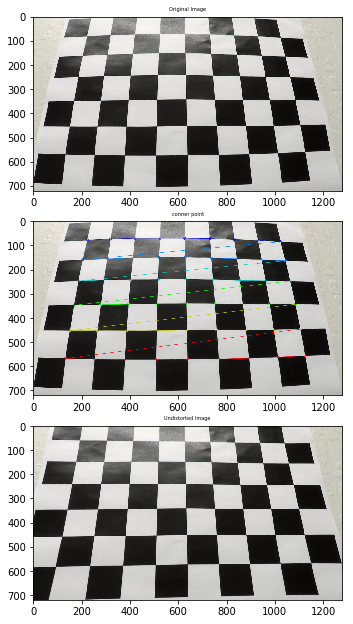

In [3]:
import numpy as np
from skimage import io
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

d=0
d=np.clip(d, 0, len(imgpoints))

img= io.imread(images[d])   

# Draw and display the corners
c_img = img.copy()
c_img = cv2.drawChessboardCorners(c_img, (9,6),imgpoints[d], ret00)
undistorted = img.copy()
undistorted= cv2.undistort(undistorted, mtx, dist, None, mtx)
    

f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(c_img)
ax2.set_title('conner point', fontsize=25)

ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [9]:
import cv2

def get_points_for_warp_operation(img_size):
    src = np.float32(
        [[(img_size[0] / 2) - 55 - 2, img_size[1] / 2 + 100], 
        [((img_size[0] / 6) - 10), img_size[1]], 
        [(img_size[0] * 5 / 6) + 35, img_size[1]], 
        [(img_size[0] / 2 + 55 + 6), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0], 
        [(img_size[0] / 4), img_size[1]], 
        [(img_size[0] * 3 / 4), img_size[1]], 
        [(img_size[0] * 3 / 4), 0]])
    return src,dst

def draw_lines_img(undist,warped,src,dst):
    disp=[undist,warped]
    
    s=src
    s=np.append(s,src[0])
    s=np.resize(s,(5,2))
    print('src.shape',src.shape,'s.shape',s.shape)
    d=dst
    d=np.append(d,dst[0])
    d=np.resize(d,(5,2))
    for k in range(4):
        cv2.line(disp[0],tuple(s[k]) ,tuple(s[k+1]), (0, 0, 255), 2)
        cv2.line(disp[1],tuple(d[k]) ,tuple(d[k+1]), (0, 0, 255), 2)
            
    plt.figure(figsize=(16,5))
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(disp[0])
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(disp[1])
    ax2.set_title('warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.

import matplotlib.pyplot as plt

def abs_sobel_thresh(img_src, orient='x', thresh_min=0, thresh_max=255):
    
    
    img = cv2.medianBlur(img_src, ksize=7)
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
   
    ################################################## 
    #plt.figure(figsize=(15, 5))
    #plt.imshow(binary_output) 
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def  image_decolor(img , N):
    
    img_src = cv2.medianBlur(img, ksize=7)
    Z = img_src.reshape((-1,3))

    # float32に変換
    Z = np.float32(Z)
    # K-Means法
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = N
    ret,label,center=cv2.kmeans(Z,
                              K,
                              None,
                              criteria,
                              10,
                              cv2.KMEANS_RANDOM_CENTERS)
   
    ##検出ラベルごとの画素数確認
    result=[]
    for i in range(K):
        result.append(np.sum(label==i))
        #print(result[i])
        
    print(img.shape)    
    print(np.sum(result)/img.shape[0])
    #行と列数にずれなきこと確認
    # print(center)
  
  
    #面積と輝度を確認して排除
    gray=[];  
    for i in range(K):
        if(result[i]>20000):
            center[i]*=0
        g=center[i][0]*0.299+center[i][1]*0.587+center[i][2]*0.114
        if(g<80):
            g=0
            center[i]=0
        gray.append(g)   
  
    #横方向の連なりを確認して排除
    for i in range(K):
        #sliding windows 
        mysliding=32
        half=mysliding//2
        for j in range(half,img.shape[0],half):
            t= j-half
            b= j+half
            if(t<0):
                continue
            if(b>=img.shape[0]):    
                continue
            cnt=(np.sum(label[t:b]==i))
            if(cnt>img.shape[1]):
                center[i]=0
                break
             
                
    
    #print(center)
    #print(gray)    
    
    # UINT8に変換
    center = np.uint8(center)
    res = center[label.flatten()]
    img_dst = res.reshape((img_src.shape))
    
    #plt.figure(figsize=(15, 5))
    #plt.imshow(img_dst) 
    

    return img_dst



[[  583.           460.        ]
 [  203.33332825   720.        ]
 [ 1101.66662598   720.        ]
 [  701.           460.        ]]
----------------------
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]
----------------------
----------------------
M [[ -5.06894686e-01  -1.50086315e+00   9.56009865e+02]
 [ -4.44089210e-16  -1.97030932e+00   9.06342285e+02]
 [ -1.30104261e-18  -2.37708415e-03   1.00000000e+00]]
----------------------
src.shape (4, 2) s.shape (5, 2)


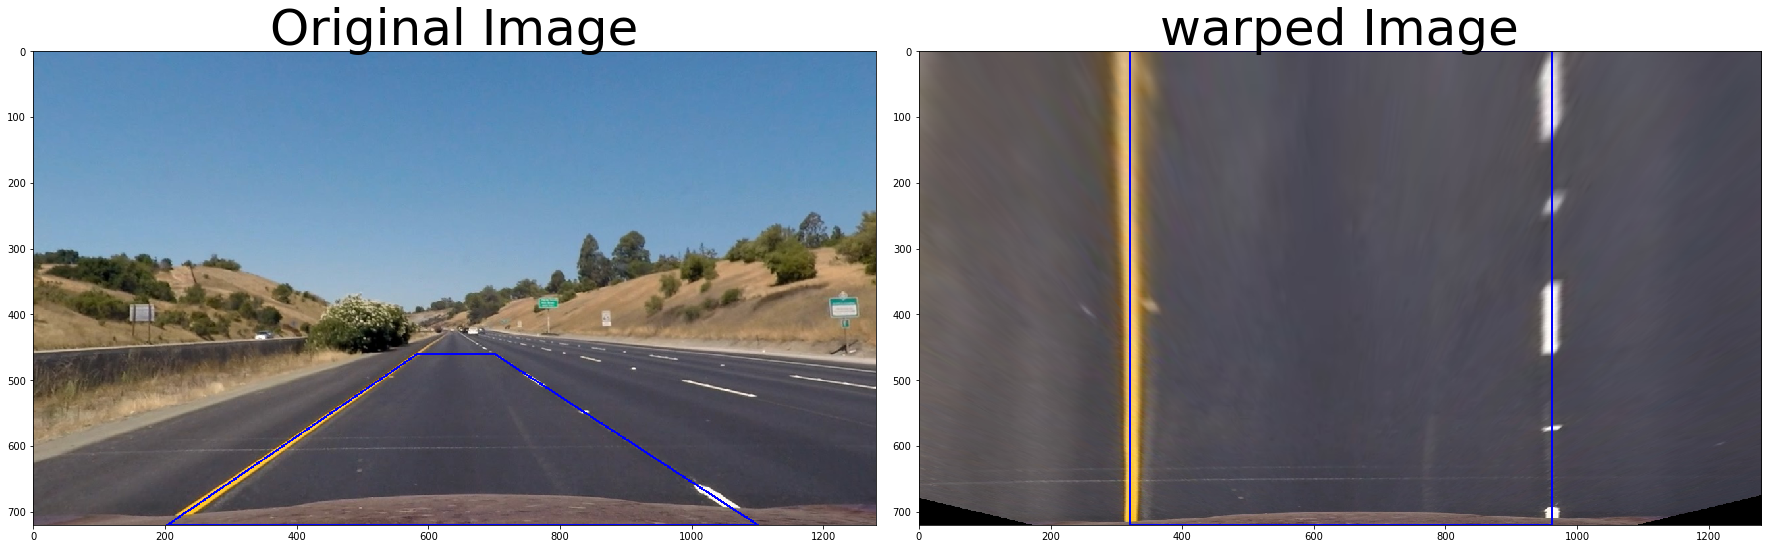

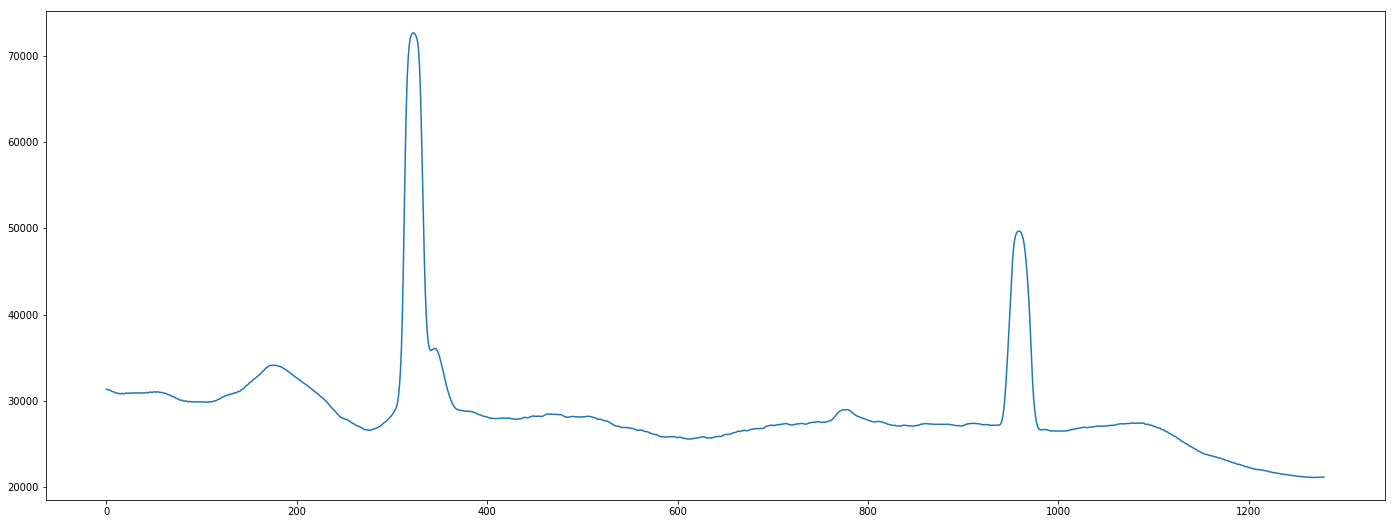

In [23]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def get_M_Matrix():
    img_size=get_tuple_img_sizeYX()
    src , dst =get_points_for_warp_operation(img_size)
    
    
    print(src)
    print('----------------------')
    print(dst)
    print('----------------------')
    M = cv2.getPerspectiveTransform(src, dst)
    print('----------------------')
    print('M',M)
    print('----------------------')
    return M,src,dst


def unwarp(img,  mtx, dist ,M):
    # Use the OpenCV undistort() function to remove distortion
    undist = img.copy()
    undist = cv2.undistort(undist, mtx, dist, None, mtx)
    
    
    #img_size = (gray.shape[1], gray.shape[0])
    img_size=get_tuple_img_sizeYX()


    warped = undist.copy()
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(warped, M, img_size)
    return undist, warped


from skimage import io    
import glob
sight=glob.glob('./test_images/straight_lines*.jpg')

img=io.imread(sight[0])
#img_size = (img.shape[1], img.shape[0])
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
M,src,dst=get_M_Matrix()
undist, warped=unwarp(img,mtx,dist,M)

disp=[undist.copy(),warped.copy()]
draw_lines_img(disp[0],disp[1],src,dst)



import numpy as np
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
histogram = np.sum(gray[gray.shape[0]//2:,:], axis=0)
plt.figure(figsize=(24, 9))
plt.plot(histogram)   

./test_warps/warp3.jpg
(720, 1280, 3)
1280.0
./test_warps/warp6.jpg
(720, 1280, 3)
1280.0
./test_warps/warp5.jpg
(720, 1280, 3)
1280.0
./test_warps/warp2.jpg
(720, 1280, 3)
1280.0
./test_warps/warp4.jpg
(720, 1280, 3)
1280.0
./test_warps/warp1.jpg
(720, 1280, 3)
1280.0


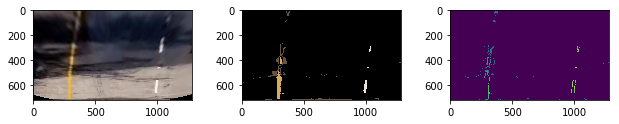

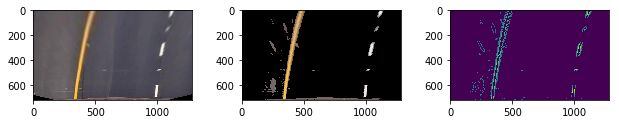

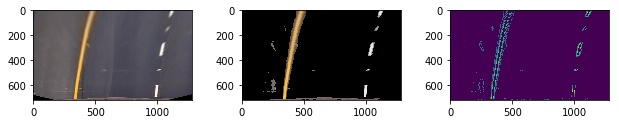

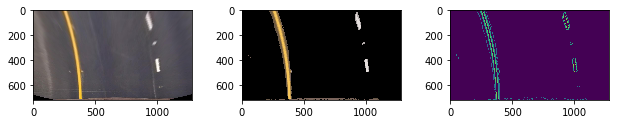

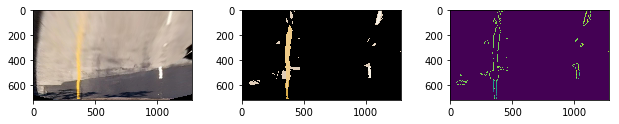

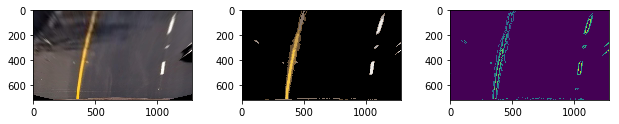

test


In [24]:
import matplotlib.pyplot as plt

from skimage import io    
import glob

import os.path
if os.path.exists('./test_warps/warp1.jpg')==False:
    sight=glob.glob('./test_images/test*.jpg')
    n=1
    for imfile in sight:
        img=io.imread(imfile)
        undist, warped=unwarp(img,mtx,dist,M)

        text='./test_warps/warp%d.jpg'%(n,)
        io.imsave(text,warped)
        n=n+1

sight=glob.glob('./test_warps/warp*.jpg')

for src_warped in sight :
    print(src_warped)
    warped=io.imread(src_warped )
    plt.figure(figsize=(32,15))
    
    
    declr= image_decolor(warped, 16);
    raw = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    edge=declr.copy()
    edge=abs_sobel_thresh(declr, 'x', 16, 255)
    gray=raw*edge


    f, (ax1, ax2,ax3 ) = plt.subplots(1,3,figsize=(8, 3))
    f.tight_layout()
    ax1.imshow(warped)
    ax2.imshow(declr)
    ax3.imshow(gray)
    
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.show()     
print('test')